### Pair Programming Asunciones Regresión Lineal


En este ejercicio de pair programming seguiréis usando el dataset que seleccionasteis.
El objetivo de este pairprgramming es que evaluéis si vuestro set de datos cumple todas las asunciones que se deben cumplir para hacer una regresión lineal. Recordamos que estas asunciones son:  

- Normalidad (ya la deberíais haber evaluado)

- Homogeneidad de varianzas.

- Independencia de las variables.

Cada asunción la deberéis testar de forma visual y analítica.

In [18]:
import numpy as np
import pandas as pd
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew # importamos esta libreria para conocer la asimetria.
from scipy.stats import kurtosistest #importamos esta libreria para conocer la curtiosis.
from scipy import stats # libreria que se utiliza para contrastar la normalidad.
from scipy.stats import kstest 
from scipy.stats import levene

import researchpy as rp


In [19]:
df = pd.read_csv('../datos/diamonds_1.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,lenght_mm,width_mm,depth_mm
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,61.8,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1. Normalidad:

Utilizamos el Test de Kolmogorov-Smirnov ya que nuestra muestra consta de más de 5000 casos.

In [20]:
#Test de Kolmogorov-Smirnov
kstest(df["carat"], 'norm')

KstestResult(statistic=0.5904707898640938, pvalue=0.0)

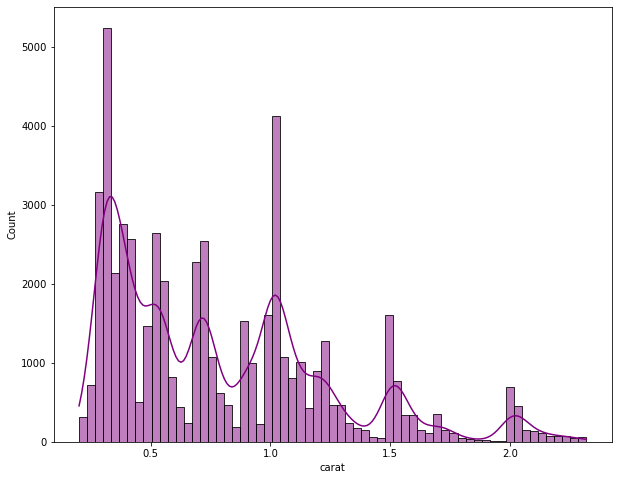

In [21]:
sns.histplot(df['carat'], kde = True, color = "purple");

Dado que el p valor es < 0.05, rechazamos hipótesis nula y concluimos que la distribución de los datos *no* es normal (confirmado por la representación gráfica). Nos va dando pistas también de qué tipo de métodos tendremos que aplicar para normalizar la muestra para la regresión lineal. De momento, todo apunta que deberemos usar 'box-cox'.

## 2. Homogeneidad de varianzas.


Dado que la distribución no es normal, optaremos por el Test de Levene utilizando la media como eje.

### Representación gráfica

Dado que todas las variables de nuestro DF son numéricas, optamos por un regplot para la representación gráfica de la homogeneidad de varianzas:

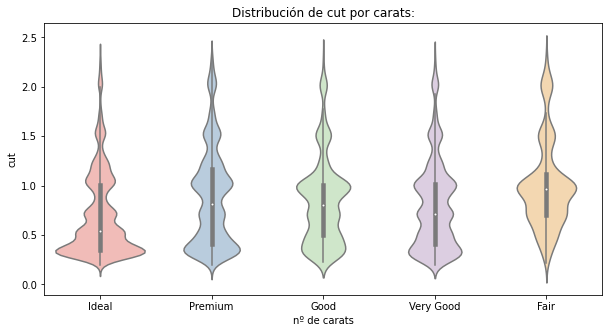

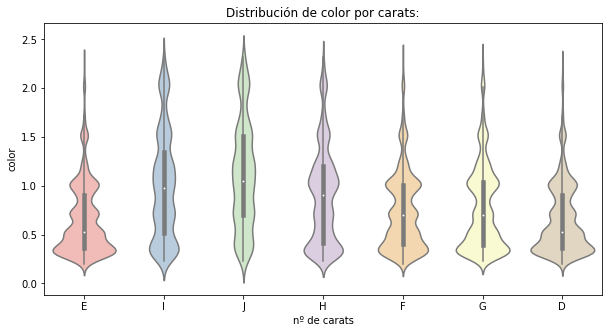

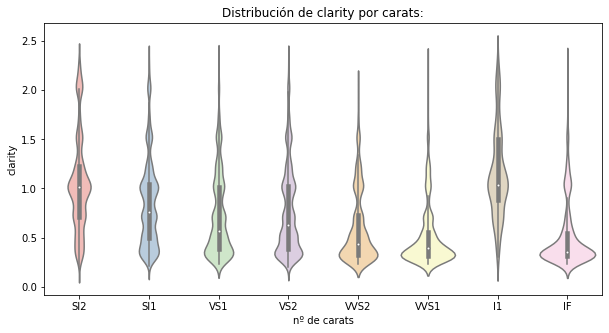

In [46]:
categoricas = df.select_dtypes(include='object')

for x in categoricas.columns:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    sns.violinplot(
        x       = x,
        y       = 'carat',
        data    = df,
        palette = 'Pastel1',
        ax      = ax
    )
    ax.set_title(f'Distribución de {x} por carats:')
    ax.set_ylabel(x)
    ax.set_xlabel('nº de carats');

#### Test de Levene:

In [24]:
stats.levene(df['carat'], df['price'], center='median', proportiontocut=0.05)

LeveneResult(statistic=50081.07417980444, pvalue=0.0)

Dado que el p valor es p < 0.05 (0.0), descartamos hipótesis nula. Por lo tanto, nuestros datos son heterocedásticos, por lo que no hay homogeneidad en las varianzas.

## 3. Independencia de las variables.


Todas nuestras variables son numéricas, por lo que para comprobar la independencia de las variables, utilizaremos el coeficiente de correlación.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   carat      53794 non-null  float64
 1   cut        53794 non-null  object 
 2   color      53794 non-null  object 
 3   clarity    53794 non-null  object 
 4   depth      53794 non-null  float64
 5   table      53794 non-null  float64
 6   price      53794 non-null  int64  
 7   lenght_mm  53794 non-null  float64
 8   width_mm   53794 non-null  float64
 9   depth_mm   53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


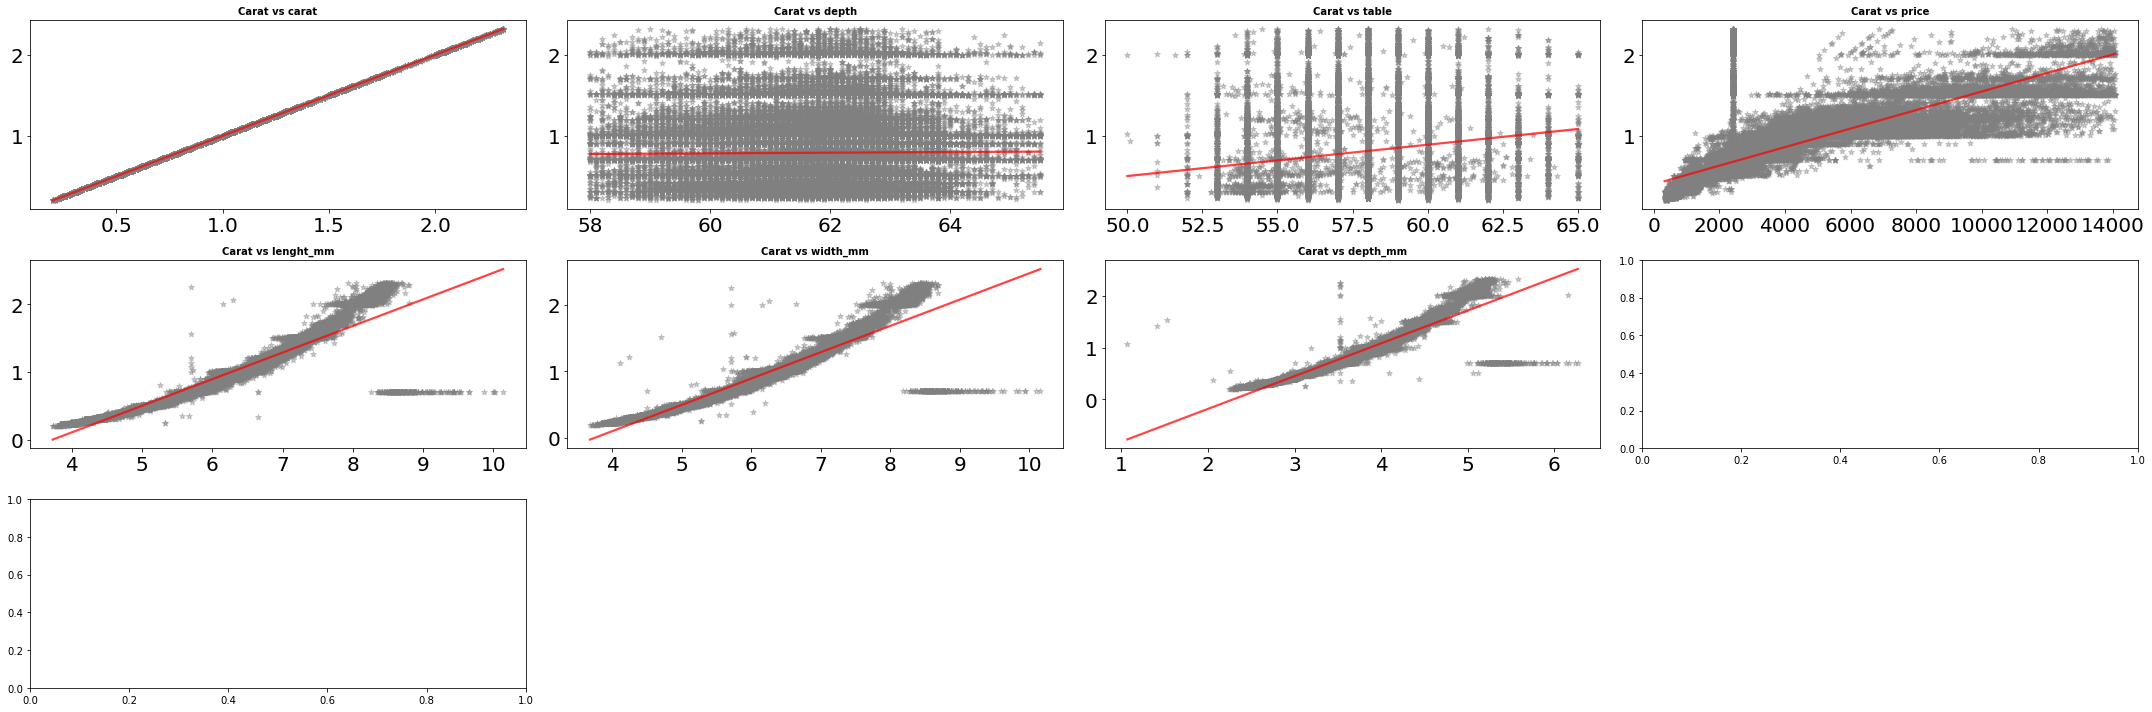

In [35]:
# Gráfico de relación entre variables predictoras (VP/VI) y la variable a predecir (VD/VR)

fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (30, 10))

axes = axes.flat

df2_columns_num = df.select_dtypes(include=np.number)

for i, colum in enumerate(df2_columns_num):
    sns.regplot(
        x = df[colum],
        y = df['carat'],
        color = "gray", 
        marker = "*", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Carat vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.delaxes(axes[-3]);

#### **Interpretación**:

A simple vista, vemos las siguientes relaciones:  

- Por lo general, la tendencia es que, a mayor carat, mayor la anchura, longitud y profundidad del diamante.

- No vemos una relación clara entre los carats y el precio. Por ello, el precio de los diamantes responde a otros factores que no son los carats.

Sin embargo, ninguna de estas relaciones el lineal. Por lo tanto, llega un momento en el que el que se dispara el ancho, profundidad y largo de los diamantes al alcanzar valor de carat concreto (generalmente a partir de 2 carats).

*Dada la no-linealidad de la relación, ptaremos por calcular la correlación con Spearman.*

In [27]:
df.corr(method='spearman')

,carat,depth,table,price,lenght_mm,width_mm,depth_mm
carat,1.000000,0.024248,0.191866,0.916074,0.989447,0.988833,0.987521
depth,0.024248,1.000000,-0.225608,0.016077,-0.023645,-0.025067,0.092185
table,0.191866,-0.225608,1.000000,0.162636,0.199686,0.193713,0.158954
price,0.916074,0.016077,0.162636,1.000000,0.913675,0.913011,0.908813
lenght_mm,0.989447,-0.023645,0.199686,0.913675,1.000000,0.997941,0.988129
width_mm,0.988833,-0.025067,0.193713,0.913011,0.997941,1.000000,0.987861
depth_mm,0.987521,0.092185,0.158954,0.908813,0.988129,0.987861,1.000000


Observamos que existe una relación muy alta entre carats y precio (0.91), siendo aún más alta la relación con el largo del diamante y los carats (0.98).

### Variables categóricas.

Utilizaremos chi cuadrado.

Las variables categóricas que tenemos son: color, claridad y corte

In [28]:
crosstab_col_cla, test_results_col_cla, expected_col_cla = rp.crosstab(df["color"], df["clarity"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")


In [29]:
crosstab_col_cla

clarity                                                      
clarity      I1    IF    SI1    SI2    VS1    VS2  VVS1  VVS2     All
color                                                                
D          0.08  0.14   3.86   2.54   1.31   3.14  0.46  1.03   12.56
E          0.19  0.29   4.50   3.17   2.38   4.58  1.22  1.84   18.17
F          0.27  0.71   3.95   2.98   2.53   4.09  1.36  1.81   17.70
G          0.28  1.26   3.66   2.87   3.98   4.35  1.85  2.68   20.94
H          0.30  0.55   4.22   2.89   2.17   3.05  1.08  1.12   15.38
I          0.17  0.27   2.64   1.68   1.79   2.17  0.66  0.68   10.05
J          0.09  0.09   1.39   0.89   1.00   1.36  0.14  0.24    5.21
All        1.38  3.32  24.23  17.01  15.16  22.73  6.78  9.40  100.00

In [30]:
test_results_col_cla

,Chi-square test,results
0,Pearson Chi-square ( 42.0) =,2038.4515
1,p-value =,0.0000
2,Cramer's V =,0.0795


Existen diferencias significativas (p=0.000) en la claridad del diamante en función de su color. Esta relación, sin embargo, es muy débil tal y como nos indica la V de Crammer (V= 0.07). 

**Diríamos que ambas variables, aunque con una relación débil, son dependientes la una de la otra.**

#### Cut y clarity

In [31]:
crosstab_cut_cla, test_results_cut_cla, expected_cut_cla = rp.crosstab(df["clarity"], df["cut"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

In [32]:
crosstab_cut_cla

cut                                       
cut      Fair  Good  Ideal Premium Very Good     All
clarity                                             
I1       0.39  0.18   0.27    0.38      0.16    1.38
IF       0.02  0.13   2.24    0.43      0.50    3.32
SI1      0.75  2.89   7.93    6.63      6.02   24.23
SI2      0.85  2.00   4.82    5.44      3.90   17.01
VS1      0.32  1.20   6.66    3.69      3.30   15.16
VS2      0.48  1.82   9.40    6.23      4.81   22.73
VVS1     0.03  0.35   3.79    1.15      1.47    6.78
VVS2     0.13  0.53   4.83    1.62      2.30    9.40
All      2.97  9.09  39.94   25.56     22.44  100.00

In [33]:
test_results_cut_cla

,Chi-square test,results
0,Pearson Chi-square ( 28.0) =,4368.3676
1,p-value =,0.0000
2,Cramer's V =,0.1425


Existen diferencias significativas en el tipo de valoración que se le da a los diamantes en función de la claridad (p=0.00), aunque la relación es débil (V=0.14).

**Diríamos que ambas variables, aunque con una relación débil, son dependientes la una de la otra.**

**QUEDA REPRESENTAR UN VIOLINPLOT CON LAS CATEGÓRICAS** 

In [34]:

# use the function regplot to make a scatterplot
#sns.regplot(x=df["cut"], y=df["clarity"])